In [1]:
!pwd

/Users/ashish1610dhiman/data_projects/fall22_hw/isye6501_aaa/hw9-1


In [2]:
!ls

homework header.docx simulation.ipynb
question 13.2.docx   ~$estion 13.2.docx


In [3]:
import simpy
import random
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

## Submission HW9 | Fall 22

-   Ashish Dhiman | [ashish.dhiman\@gatech.edu](mailto:ashish.dhiman@gatech.edu)

-   Abhinav Arun | [aarun60\@gatech.edu](mailto:aarun60gatech.edu)

-   Anshit Verma | [averma373\@gatech.edu](mailto:averma373@gatech.edu)

### Refrences
http://simpy.readthedocs.io/en/latest/simpy_intro/basic_concepts.html  
https://realpython.com/simpy-simulating-with-python/#brainstorming-a-simulation-algorithm

## We have a Airport, we simplify its modelling as the following steps:
### 1. User arriving at airport, with mean interarrival rate m1 = 0.2 mins | Poisson
### 2. Get Served by servers, with m2 = 0.75 mins | Exponential
### 3. move to personal check queue, where scanning time ~U(0.5,1) | Uniform


In [4]:
wait_times = [] #store wait time of each individual user

In [5]:
m1 = 0.2 #mean rate of arrival for users at airport
m2 = 0.75 #mean serving time

In [6]:
#Simulation Classs for Airport
class Airport(object):
    def __init__(self, env, n_server, n_checker):
        self.env = env
        self.server = simpy.Resource(env, n_server)
        self.checker = simpy.Resource(env, n_checker)

    def get_served(self, user, m2):
        yield self.env.timeout(random.expovariate(1/m2))
        
    def get_scanned(self, user):
        yield self.env.timeout(random.uniform(0.5,1))

In [7]:
#Function to model lifecycle of a user at airport
def go_to_airport(env, user, airport, m2):
    #1. user arrives at the airport
    arrival_time = env.now
    
    #2. Get Served at Airport
    with airport.server.request() as request:
        yield request
        yield env.process(airport.get_served(user, m2))
        
    #3. Get Scanned at Airport
    with airport.checker.request() as request:
        yield request
        yield env.process(airport.get_scanned(user))
        
    # Calculate wait time
    wait_times.append(env.now - arrival_time)

In [8]:
def run_simulation(env, n_server, n_checker, m1, m2):
    airport = Airport(env, n_server, n_checker)
    
    #we start with only one user cureecntly at airport
    for user in range(1):
        env.process(go_to_airport(env, user, airport, m2))

    while True:
        yield env.timeout(random.expovariate(1/m1))  # Arrival of new user as defined my m1
        user += 1
        env.process(go_to_airport(env, user, airport, m2))

In [9]:
def get_average_wait_time(wait_times):
    average_wait = sum(wait_times)/len(wait_times)
    return (average_wait)

In [10]:
random.seed(42)

In [11]:
env = simpy.Environment()
env.process(run_simulation(env, n_server = 20, n_checker = 10, m1 = m1, m2 = m2))
env.run(until=60*24*7) #1 week simulation

In [12]:
len(wait_times)

50314

### Run Simulation programmatically parameterised by n_server and n_checker

In [13]:
m1 = 0.2
m2 = 0.75

In [14]:
simulation_result = pd.DataFrame()
for n_server in [1,2,3,4,5,6,7,8,9,10]:
    for n_checker in [1,2,3,4,5,6,7,8,9,10]:
        temp = pd.DataFrame()
        wait_times = [] #store wait time of each individual user
        env = simpy.Environment()
        env.process(run_simulation(env, n_server = n_server, n_checker = n_checker, m1 = m1, m2 = m2))
        env.run(until=60*24*7)
        temp["n_server"] = [n_server]
        temp["n_checker"] = [n_checker]
        temp["avg_wait_time"] = [get_average_wait_time(wait_times)]
        simulation_result = simulation_result.append(temp)

### Surface Plot of Avergage Wait time

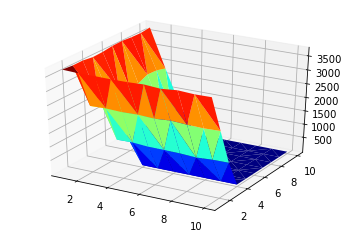

In [15]:
fig = plt.figure()
ax = plt.axes(projection ='3d')

ax.plot_trisurf(simulation_result.n_server, simulation_result.n_checker, simulation_result.avg_wait_time,\
                cmap=cm.jet, linewidth=0.2)
plt.show()

In [16]:
crosstab = simulation_result.pivot_table(index=["n_checker"],columns=["n_server"],values=["avg_wait_time"])

In [17]:
def lt_15min(cell_value):

    highlight = 'background-color: yellow;'
    default = ''

    if type(cell_value) in [float, int]:
        if cell_value <=15.0:
            return highlight
    return default

crosstab.style.applymap(lt_15min)

### Discussion
1. As seen in the highlighted cells above, for any n_server>=4 and n_checker>=4. We have avg wait time less than 15 mins

2. Our simulation seems reasonable, since if we keep n_server constant at 1, it creates a bottle neck in the Airport system, and in this case increase in n_checker does not improve wait times. Similar beahviour is seen for n_checker =1, with which n_server becomes redundant.

3. Apart from the bottle neck, increasing both n_checker and n_server improves wait time. Although, the rate of improvement increases and then plateaus at higher values.